In [1]:
# 02_entity_similarity_analysis
#
# created by LuYF-Lemon-love <luyanfeng_nlp@qq.com> on March 4, 2023
# updated by LuYF-Lemon-love <luyanfeng_nlp@qq.com> on March 12, 2023
#
# 该脚本展示了如何分析训练的实体嵌入.
#
# 需要的包:
#          numpy
#          csv
#          matplotlib
#          sklearn
#          MulticoreTSNE, 安装命令为:
#                pip install cmake==3.18.4 -i https://pypi.tuna.tsinghua.edu.cn/simple
#                pip install MulticoreTSNE -i https://pypi.tuna.tsinghua.edu.cn/simple
#
# 需要的文件:
#          ../01-model/ckpts/TransE_l1_All_DRKG_0/All_DRKG_TransE_l1_entity.npy
#          ../01-model/ckpts/TransE_l2_All_DRKG_0/All_DRKG_TransE_l2_entity.npy
#          ../01-model/ckpts/ComplEx_All_DRKG_0/All_DRKG_ComplEx_entity.npy
#          ../01-model/ckpts/RotatE_All_DRKG_0/All_DRKG_RotatE_entity.npy
#          ../../data/drkg/entities.tsv
#
# 源教程链接: https://github.com/gnn4dr/DRKG/blob/master/embedding_analysis/Entity_similarity_analysis.ipynb

# DRKG Entity Embedding Similarity Analysis

这个 notebook 展示了如何分析训练的实体嵌入.

在这个例子中, 我们首先加载训练的实体嵌入向量, 然后将它们映射回原始的实体名, 最后应用下面方法分析它们:

- 投射实体嵌入进入低维空间并可视化它们的分布.

In [2]:
import numpy as np
import csv
import sklearn
import matplotlib.pyplot as plt
from MulticoreTSNE import MulticoreTSNE as TSNE
from sklearn.decomposition import PCA

## Loading Entity ID Mapping

In [3]:
entity2id = {}
id2entity = {}

with open("../../data/drkg/entities.tsv", newline='', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile, delimiter='\t', fieldnames=['id','entity'])
    for row_val in reader:
        id = row_val['id']
        entity = row_val['entity']

        entity2id[entity] = int(id)
        id2entity[int(id)] = entity

print("Number of entities: {}".format(len(entity2id)))

Number of entities: 97238


## Alzheimer's disease

- Disease::DOID:10652: Alzheimer's disease, 阿尔茨海默病

- Disease::MESH:C536599: Alzheimer's disease without Neurofibrillary tangles, 无神经纤维缠结的阿尔茨海默病

- Disease::MESH:D000544: Alzheimer Disease, 阿尔茨海默病

In [4]:
AD_disease_list = [
'Disease::DOID:10652',
'Disease::MESH:C536599',
'Disease::MESH:D000544'
]

In [5]:
AD_disease_list

['Disease::DOID:10652', 'Disease::MESH:C536599', 'Disease::MESH:D000544']

## Loading Entity Embeddings

In [6]:
TransE_l1_entity_emb = np.load('../01-model/ckpts/TransE_l1_All_DRKG_0/All_DRKG_TransE_l1_entity.npy')
TransE_l2_entity_emb = np.load('../01-model/ckpts/TransE_l2_All_DRKG_0/All_DRKG_TransE_l2_entity.npy')
ComplEx_entity_emb = np.load('../01-model/ckpts/ComplEx_All_DRKG_0/All_DRKG_ComplEx_entity.npy')
RotatE_entity_emb = np.load('../01-model/ckpts/RotatE_All_DRKG_0/All_DRKG_RotatE_entity.npy')
print(TransE_l1_entity_emb.shape, TransE_l2_entity_emb.shape, ComplEx_entity_emb.shape, RotatE_entity_emb.shape)

(97238, 400) (97238, 400) (97238, 400) (97238, 400)


## General Entity Embedding Clustering

这里我们使用 PCA 和 t-SNE 将实体嵌入降维, 然后可视化它们的分布.

In [7]:
# 将实体按照源数据集分类
dataset_id = {}
for entity_name, i in entity2id.items():
    entity_key = entity_name.split('::')[0]
    if dataset_id.get(entity_key, None) is None:
        dataset_id[entity_key] = []
    dataset_id[entity_key].append(i)

In [8]:
# 降维并转置, 降维的结果每次都不同
try:
    X_TransE_l1_embedded = np.load('./result/entity/X_TransE_l1_embedded.npy')
    X_TransE_l2_embedded = np.load('./result/entity/X_TransE_l2_embedded.npy')
    X_ComplEx_embedded = np.load('./result/entity/X_ComplEx_embedded.npy')
    X_RotatE_embedded = np.load('./result/entity/X_RotatE_embedded.npy')
    print("加载之前保存好的 embedded.")
except Exception as e :
    print("重新计算 embedded.")
    
    # 遵从 scikit-learn 官方的建议, 利用 PCA 先将 entity_emb 降维到 30
    # https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html#sklearn.manifold.TSNE
    TransE_l1_embed_PCA = PCA(n_components = 30).fit_transform(TransE_l1_entity_emb)
    TransE_l2_embed_PCA = PCA(n_components = 30).fit_transform(TransE_l2_entity_emb)
    ComplEx_embed_PCA = PCA(n_components = 30).fit_transform(ComplEx_entity_emb)
    RotatE_embed_PCA = PCA(n_components = 30).fit_transform(RotatE_entity_emb)
    
    # 降维并转置
    X_TransE_l1_embedded = TSNE(n_components=2, n_jobs = 32).fit_transform(TransE_l1_embed_PCA).T
    X_TransE_l2_embedded = TSNE(n_components=2, n_jobs = 32).fit_transform(TransE_l2_embed_PCA).T
    X_ComplEx_embedded = TSNE(n_components=2, n_jobs = 32).fit_transform(ComplEx_embed_PCA).T
    X_RotatE_embedded = TSNE(n_components=2, n_jobs = 32).fit_transform(RotatE_embed_PCA).T
    np.save('./result/entity/X_TransE_l1_embedded.npy', X_TransE_l1_embedded)
    np.save('./result/entity/X_TransE_l2_embedded.npy', X_TransE_l2_embedded)
    np.save('./result/entity/X_ComplEx_embedded.npy', X_ComplEx_embedded)
    np.save('./result/entity/X_RotatE_embedded.npy', X_RotatE_embedded)

加载之前保存好的 embedded.


In [9]:
colors = [
    'grey',
    'green',
    'red',
    'blue',
    'cyan',
    'magenta',
    'yellow',
    'black',
    'purple',
    'plum',
    'orange',
    'lightgreen',
    'sienna',
]

In [10]:
len(colors)

13

In [11]:
len(dataset_id.items())

13

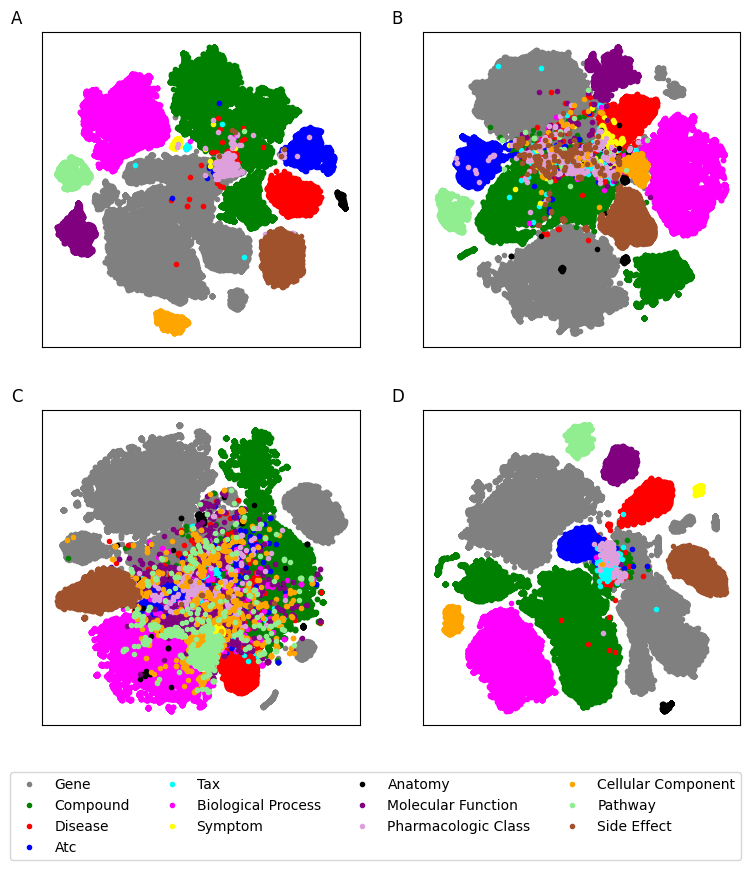

In [12]:
# 绘制，不画 treats
plt.figure(figsize = (9, 9))

# TransE_l1
ax = plt.subplot(221)
plt.title('A', loc = 'left', position = (-0.1, -0.1))
i = 0
for key, val in dataset_id.items():
    val = np.asarray(val, dtype=int)
    plt.plot(X_TransE_l1_embedded[0][val], X_TransE_l1_embedded[1][val], '.', label=key, color = colors[i])
    i += 1

plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
    
# TransE_l2
plt.subplot(222)
plt.title('B', loc = 'left', position = (-0.1, -0.1))
i = 0
for key, val in dataset_id.items():
    val = np.asarray(val, dtype=int)
    plt.plot(X_TransE_l2_embedded[0][val], X_TransE_l2_embedded[1][val], '.', label=key, color = colors[i])
    i += 1

plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)

# ComplEx
plt.subplot(223)
plt.title('C', loc = 'left', position = (-0.1, -0.1))
i = 0
for key, val in dataset_id.items():
    val = np.asarray(val, dtype=int)
    plt.plot(X_ComplEx_embedded[0][val], X_ComplEx_embedded[1][val], '.', label=key, color = colors[i])
    i += 1

plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)

# RotatE
plt.subplot(224)
plt.title('D', loc = 'left', position = (-0.1, -0.1))
i = 0
for key, val in dataset_id.items():
    val = np.asarray(val, dtype=int)
    plt.plot(X_RotatE_embedded[0][val], X_RotatE_embedded[1][val], '.', label=key, color = colors[i])
    i += 1

plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
lgd = plt.legend(loc = 'lower center', ncols = 4, bbox_to_anchor=(-0.15, -0.45))
plt.savefig('./result/entity/entity_no_AD.svg', bbox_extra_artists=(lgd,), bbox_inches='tight', format='svg')
plt.savefig('./result/entity/entity_no_AD.png', bbox_extra_artists=(lgd,), bbox_inches='tight', format='png')

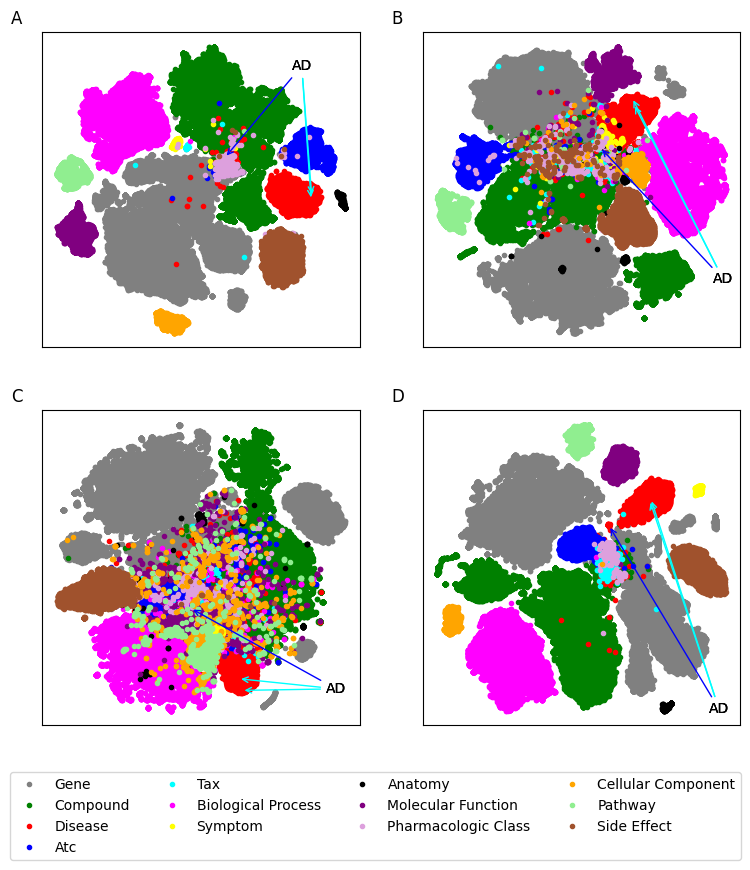

In [13]:
# 绘制
plt.figure(figsize = (9, 9))

# TransE_l1
ax = plt.subplot(221)
plt.title('A', loc = 'left', position = (-0.1, -0.1))
i = 0
for key, val in dataset_id.items():
    val = np.asarray(val, dtype=int)
    plt.plot(X_TransE_l1_embedded[0][val], X_TransE_l1_embedded[1][val], '.', label=key, color = colors[i])
    i += 1

for i in range(len(AD_disease_list)):
    plt.annotate('AD',
                 xy=(X_TransE_l1_embedded[0][entity2id[AD_disease_list[i]]], X_TransE_l1_embedded[1][entity2id[AD_disease_list[i]]]),
                 xytext=(20.0, 25.0),
                 arrowprops=dict(arrowstyle = '->', color = 'blue' if i == 0 else 'cyan', linewidth = 1.0),
                )
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
    
# TransE_l2
plt.subplot(222)
plt.title('B', loc = 'left', position = (-0.1, -0.1))
i = 0
for key, val in dataset_id.items():
    val = np.asarray(val, dtype=int)
    plt.plot(X_TransE_l2_embedded[0][val], X_TransE_l2_embedded[1][val], '.', label=key, color = colors[i])
    i += 1

for i in range(len(AD_disease_list)):
    plt.annotate('AD',
                 xy=(X_TransE_l2_embedded[0][entity2id[AD_disease_list[i]]], X_TransE_l2_embedded[1][entity2id[AD_disease_list[i]]]),
                 xytext=(28.0, -20.0),
                 arrowprops=dict(arrowstyle = '->', color = 'blue' if i == 0 else 'cyan', linewidth = 1.0),
                )
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)

# ComplEx
plt.subplot(223)
plt.title('C', loc = 'left', position = (-0.1, -0.1))
i = 0
for key, val in dataset_id.items():
    val = np.asarray(val, dtype=int)
    plt.plot(X_ComplEx_embedded[0][val], X_ComplEx_embedded[1][val], '.', label=key, color = colors[i])
    i += 1

for i in range(len(AD_disease_list)):
    plt.annotate('AD',
                 xy=(X_ComplEx_embedded[0][entity2id[AD_disease_list[i]]], X_ComplEx_embedded[1][entity2id[AD_disease_list[i]]]),
                 xytext=(25.0, -25.0),
                 arrowprops=dict(arrowstyle = '->', color = 'blue' if i == 0 else 'cyan', linewidth = 1.0),
                )
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)

# RotatE
plt.subplot(224)
plt.title('D', loc = 'left', position = (-0.1, -0.1))
i = 0
for key, val in dataset_id.items():
    val = np.asarray(val, dtype=int)
    plt.plot(X_RotatE_embedded[0][val], X_RotatE_embedded[1][val], '.', label=key, color = colors[i])
    i += 1

for i in range(len(AD_disease_list)):
    plt.annotate('AD',
                 xy=(X_RotatE_embedded[0][entity2id[AD_disease_list[i]]], X_RotatE_embedded[1][entity2id[AD_disease_list[i]]]),
                 xytext=(25.0, -25.0),
                 arrowprops=dict(arrowstyle = '->', color = 'blue' if i == 0 else 'cyan', linewidth = 1.0),
                )
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
lgd = plt.legend(loc = 'lower center', ncols = 4, bbox_to_anchor=(-0.15, -0.45))
plt.savefig('./result/entity/entity.svg', bbox_extra_artists=(lgd,), bbox_inches='tight', format='svg')
plt.savefig('./result/entity/entity.png', bbox_extra_artists=(lgd,), bbox_inches='tight', format='png')